# London Smart meters dataset

https://data.london.gov.uk/dataset/smartmeter-energy-use-data-in-london-households

## Transform extracting features with TSFEL

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import re

In [2]:
import tsfel

In [3]:
DATASET_ID = 2 # 'FULL'
DECIMATION_RATE = 0.1 # valid only if dataset is FULL

In [5]:
dataset_root = Path('../../Dataset')

In [6]:
if isinstance( DATASET_ID, int )  :
    dataset = sorted(list((dataset_root/'partitioned/Small LCL Data').glob('*.csv')))[ DATASET_ID ]
else :
    dataset = dataset_root/'full/CC_LCL-FullData.csv'

In [7]:
%%time
df = pd.read_csv(dataset, names = ['ID','type','timestamp','consumption'], header = 0) 

CPU times: user 392 ms, sys: 42.6 ms, total: 435 ms
Wall time: 539 ms


In [8]:
ids = df.ID.unique()
if not isinstance( DATASET_ID, int )  :
    ids = np.random.choice( ids, int( len(ids) * DECIMATION_RATE ) )
    df = df.query( 'ID in @ids' )

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   ID           1000000 non-null  object
 1   type         1000000 non-null  object
 2   timestamp    1000000 non-null  object
 3   consumption  1000000 non-null  object
dtypes: object(4)
memory usage: 30.5+ MB


In [10]:
%%time
df = (df
      .assign( timestamp = pd.to_datetime(df.timestamp) )
      .assign( consumption = pd.to_numeric( df.consumption, errors = 'coerce' ) )
      .assign( invalid = lambda x : x.consumption.isna() )
#      .assign( consumption = lambda x : x.consumption.fillna( -1.0 ) )
    )
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   ID           1000000 non-null  object        
 1   type         1000000 non-null  object        
 2   timestamp    1000000 non-null  datetime64[ns]
 3   consumption  999970 non-null   float64       
 4   invalid      1000000 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), object(2)
memory usage: 31.5+ MB
CPU times: user 378 ms, sys: 31.9 ms, total: 409 ms
Wall time: 408 ms


In [11]:
df.tail()

,ID,type,timestamp,consumption,invalid
999995,MAC000363,Std,2012-04-06 16:00:00,0.081,False
999996,MAC000363,Std,2012-04-06 16:30:00,0.108,False
999997,MAC000363,Std,2012-04-06 17:00:00,0.070,False
999998,MAC000363,Std,2012-04-06 17:30:00,0.071,False
999999,MAC000363,Std,2012-04-06 18:00:00,0.069,False


In [12]:
%%time
df_series = (  df
               .assign( year = df.timestamp.dt.year.astype( str ) )
               .assign( month = df.timestamp.dt.month.apply( lambda d : f'{d:02d}' ) ) 
               .assign( day = df.timestamp.dt.day.apply( lambda d : f'{d:02d}' ) ) 
               .assign( time = df.timestamp.dt.time.astype( str ) )
               .assign( year_month = lambda x : x.year.str.cat( x.month, sep = '-' ) )
               .assign( day_time = lambda x : x.day.str.cat( x.time, sep = '-' ) )
               .assign( sample_name = lambda x : x.ID.str.cat( x.year_month, sep = '-' ) )
               [['sample_name','day_time','consumption']]
               .groupby( ['sample_name','day_time'] )
               .sum()
               .unstack( 'day_time' )             
            )


CPU times: user 3.01 s, sys: 309 ms, total: 3.32 s
Wall time: 3.32 s


In [13]:
df_series

consumption                                                  \
day_time          01-00:00:00 01-00:30:00 01-01:00:00 01-01:30:00 01-02:00:00   
sample_name                                                                     
MAC000326-2012-04         NaN         NaN         NaN         NaN         NaN   
MAC000326-2012-05       0.100       0.247       0.837       0.119       0.096   
MAC000326-2012-06       0.119       0.096       0.095       0.079       0.093   
MAC000326-2012-07       0.393       0.087       0.060       0.045       0.061   
MAC000326-2012-08       0.074       0.050       0.055       0.049       0.056   
...                       ...         ...         ...         ...         ...   
MAC000362-2013-12       0.143       0.043       0.020       0.019       0.054   
MAC000362-2014-01       0.062       0.022       0.018       0.032       0.062   
MAC000362-2014-02       0.119       0.153       0.171       0.068       0.020   
MAC000363-2012-03         NaN         NaN         NaN         NaN         NaN   
MAC000363-2012-04       0.261       0.311       0.035       0.034       0.033   

                                                                               \
day_time          01-02:30:00 01-03:00:00 01-03:30:00 01-04:00:00 01-04:30:00   
sample_name                                                                     
MAC000326-2012-04         NaN         NaN         NaN         NaN         NaN   
MAC000326-2012-05       0.122       0.713       0.090       0.088       0.131   
MAC000326-2012-06       0.093       0.099       0.079       0.090       0.108   
MAC000326-2012-07       0.043       0.064       0.040       0.062       0.042   
MAC000326-2012-08       0.047       0.053       0.054       0.045       0.059   
...                       ...         ...         ...         ...         ...   
MAC000362-2013-12       0.059       0.020       0.031       0.044       0.074   
MAC000362-2014-01       0.034       0.019       0.030       0.073       0.058   
MAC000362-2014-02       0.032       0.063       0.043       0.031       0.032   
MAC000363-2012-03         NaN         NaN         NaN         NaN         NaN   
MAC000363-2012-04       0.030       0.063       0.057       0.021       0.019   

                   ...                                                  \
day_time           ... 31-19:00:00 31-19:30:00 31-20:00:00 31-20:30:00   
sample_name        ...                                                   
MAC000326-2012-04  ...         NaN         NaN         NaN         NaN   
MAC000326-2012-05  ...       0.129       0.217       0.075       0.135   
MAC000326-2012-06  ...         NaN         NaN         NaN         NaN   
MAC000326-2012-07  ...       0.086       0.210       0.445       0.701   
MAC000326-2012-08  ...       0.460       0.530       0.498       0.543   
...                ...         ...         ...         ...         ...   
MAC000362-2013-12  ...       0.119       0.179       0.167       0.121   
MAC000362-2014-01  ...       0.043       0.109       0.146       0.150   
MAC000362-2014-02  ...         NaN         NaN         NaN         NaN   
MAC000363-2012-03  ...       0.020       0.026       0.066       0.061   
MAC000363-2012-04  ...         NaN         NaN         NaN         NaN   

                                                                               \
day_time          31-21:00:00 31-21:30:00 31-22:00:00 31-22:30:00 31-23:00:00   
sample_name                                                                     
MAC000326-2012-04         NaN         NaN         NaN         NaN         NaN   
MAC000326-2012-05       0.104       0.131       0.090       0.100       0.094   
MAC000326-2012-06         NaN         NaN         NaN         NaN         NaN   
MAC000326-2012-07       0.658       1.436       0.848       0.680       0.441   
MAC000326-2012-08       0.514       1.186       0.880       0.568       0.364   
...                       ...         ...         ...         .

In [14]:
# build a dataframe as required by tsfel to extract features:
# rows are timestamps and columns are series names
X = df_series.T.droplevel(0).fillna(0)

# uncomment the following to reduce the samples to a subset, to explore results
# choosen_idxs = np.random.choice(len(df_series), size = 15, replace = False)
# X = df_series.iloc[choosen_idxs].T.droplevel(0).fillna(0)

In [15]:
X.head()

sample_name,MAC000326-2012-04,MAC000326-2012-05,MAC000326-2012-06,MAC000326-2012-07,MAC000326-2012-08,MAC000326-2012-09,MAC000326-2012-10,MAC000326-2012-11,MAC000326-2012-12,MAC000326-2013-01,...,MAC000362-2013-07,MAC000362-2013-08,MAC000362-2013-09,MAC000362-2013-10,MAC000362-2013-11,MAC000362-2013-12,MAC000362-2014-01,MAC000362-2014-02,MAC000363-2012-03,MAC000363-2012-04
day_time,,,,,,,,,,,,,,,,,,,,,
01-00:00:00,0.0,0.100,0.119,0.393,0.074,0.146,0.041,0.840,1.666,0.168,...,0.084,0.018,0.040,0.019,0.019,0.143,0.062,0.119,0.0,0.261
01-00:30:00,0.0,0.247,0.096,0.087,0.050,0.052,0.062,1.195,1.527,0.195,...,0.019,0.025,0.063,0.057,0.064,0.043,0.022,0.153,0.0,0.311
01-01:00:00,0.0,0.837,0.095,0.060,0.055,0.064,0.029,0.188,0.796,0.791,...,0.060,0.063,0.060,0.058,0.053,0.020,0.018,0.171,0.0,0.035
01-01:30:00,0.0,0.119,0.079,0.045,0.049,0.032,0.073,0.046,0.261,0.603,...,0.059,0.061,0.034,0.018,0.019,0.019,0.032,0.068,0.0,0.034
01-02:00:00,0.0,0.096,0.093,0.061,0.056,0.068,0.030,0.052,0.248,0.148,...,0.019,0.022,0.030,0.019,0.019,0.054,0.062,0.020,0.0,0.033


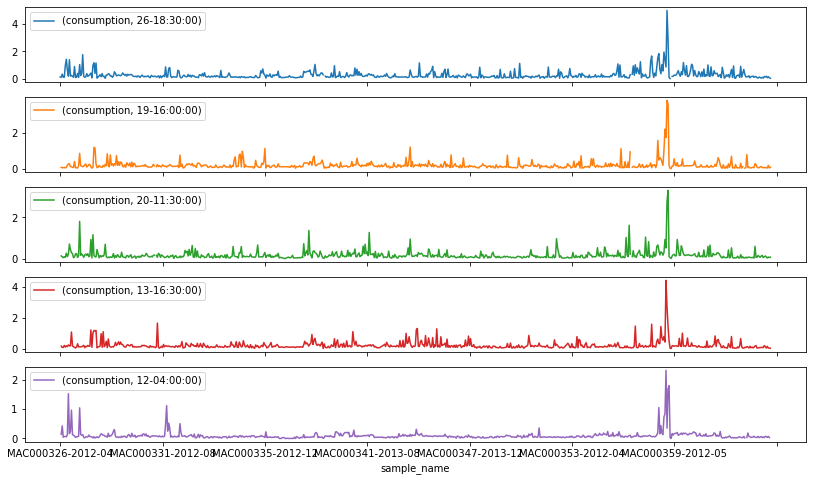

In [16]:
# Show some ranomd series
df_series.T.sample(5).T.plot( figsize = (14,8), subplots = True )
plt.show()

In [17]:
# synthetic dataset used to check columns ordering
# X = pd.concat([pd.Series([0]*10) for _ in range(10)] + [pd.Series([10]*10) for _ in range(2)], axis = 1)
# X.columns = [f'serie_{x}' for x in range(12)]
# X

In [18]:
# build config file to drive tsfel 

#cfg_file = tsfel.get_features_by_domain()               # All features will be extracted.
cfg_file = tsfel.get_features_by_domain("statistical")  # All statistical domain features will be extracted
#cfg_file = tsfel.get_features_by_domain("temporal")     # All temporal domain features will be extracted
#cfg_file = tsfel.get_features_by_domain("spectral")     # All spectral domain features will be extracted

In [19]:
# Xf is the feature extraction dataset from tsfel
# it is a single row of features with feature names in the format f'{s}_{name}' 
# where 's' is the column number in the original dataset and 'name' is the feature name.
# Feratures are orederd in alphabetical order thus features of column #11 come after 
# features of column #1
# This is beacuse tsfel is designed with multivariate ts in mind, not multiple ts.

Xf = tsfel.time_series_features_extractor(cfg_file, X ) 

*** Feature extraction started ***
16


/tmp/ipykernel_3412/3264033782.py:8: UserWarning: Using default sampling frequency set in configuration file.
  Xf = tsfel.time_series_features_extractor(cfg_file, X )



*** Feature extraction finished ***


In [20]:
Xf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Columns: 25056 entries, 0_ECDF Percentile Count_0 to 9_Variance
dtypes: float64(25056)
memory usage: 195.9 KB


In [21]:
# Convert the features row in a features table with time series in the rows and relevent features in the columns
df_features = ( Xf
  .T    # Transpose to have the columns as index
  .set_index( pd.MultiIndex.from_tuples( \
      [(int(i),s) for i,s in [re.match(r'(\d+)_(.+)',idx).groups() for idx in Xf.columns]]
   ))  # build a mulitindex from the current index
  .T   # Set the index back on the columns
  .stack(0)     # Level 0 of multiindex columns is the time series number in the order of the original dataset
  .droplevel(0) # index level 0 is just '0' because Xf had only one row
  .sort_index() # probably useless but there is noguarantee about column order from tsfel
  .set_index(X.columns) # rename the index as the names of the time series
)

In [22]:
df_features

,ECDF Percentile Count_0,ECDF Percentile Count_1,ECDF Percentile_0,ECDF Percentile_1,ECDF_0,ECDF_1,ECDF_2,ECDF_3,ECDF_4,ECDF_5,...,Max,Mean,Mean absolute deviation,Median,Median absolute deviation,Min,Root mean square,Skewness,Standard deviation,Variance
sample_name,,,,,,,,,,,,,,,,,,,,,
MAC000326-2012-04,298.0,1194.0,0.000,0.135,0.00067,0.00134,0.002009,0.002679,0.003349,0.004019,...,3.385,0.144786,0.210810,0.000,0.000,0.0,0.416125,3.902327,0.390124,0.152197
MAC000326-2012-05,298.0,1194.0,0.085,0.412,0.00067,0.00134,0.002009,0.002679,0.003349,0.004019,...,4.964,0.333469,0.307638,0.139,0.066,0.0,0.588819,3.489076,0.485290,0.235506
MAC000326-2012-06,298.0,1194.0,0.047,0.361,0.00067,0.00134,0.002009,0.002679,0.003349,0.004019,...,3.000,0.239825,0.228485,0.088,0.053,0.0,0.418171,2.993577,0.342565,0.117351
MAC000326-2012-07,298.0,1194.0,0.046,0.188,0.00067,0.00134,0.002009,0.002679,0.003349,0.004019,...,1.636,0.143738,0.120637,0.073,0.028,0.0,0.243453,3.462157,0.196491,0.038609
MAC000326-2012-08,298.0,1194.0,0.052,0.168,0.00067,0.00134,0.002009,0.002679,0.003349,0.004019,...,1.951,0.136925,0.101345,0.079,0.028,0.0,0.218315,4.199789,0.170038,0.028913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MAC000362-2013-12,298.0,1194.0,0.031,0.135,0.00067,0.00134,0.002009,0.002679,0.003349,0.004019,...,0.999,0.085740,0.050522,0.065,0.034,0.0,0.113690,4.609033,0.074659,0.005574
MAC000362-2014-01,298.0,1194.0,0.031,0.126,0.00067,0.00134,0.002009,0.002679,0.003349,0.004019,...,0.860,0.082388,0.046329,0.065,0.034,0.0,0.107410,4.342811,0.068915,0.004749
MAC000362-2014-02,298.0,1194.0,0.024,0.110,0.00067,0.00134,0.002009,0.002679,0.003349,0.004019,...,1.127,0.067707,0.045725,0.050,0.026,0.0,0.102113,6.129102,0.076439,0.005843


# Save ingested data

In [23]:
if isinstance( DATASET_ID, int )  :
    out_file_series = f'ingested/series_{DATASET_ID}.csv' 
    out_file_features = f'ingested/fsfel_features_{DATASET_ID}.csv' 
else :
    out_file_series = f'ingested/series_full_{DECIMATION_RATE}.csv' 
    out_file_features = f'ingested/fsfel_features_full_{DECIMATION_RATE}.csv' 
    
df_series.to_csv( dataset_root/out_file_series )
print(f'Series dataframe saved to {dataset_root/out_file_series}')

df_features.to_csv( dataset_root/out_file_features )
print(f'Features dataframe saved to {dataset_root/out_file_features}')


Series dataframe saved to ../../Dataset/ingested/series_2.csv
Features dataframe saved to ../../Dataset/ingested/fsfel_features_2.csv
